In [1]:
import math
import numpy as np
from PIL import Image, ImageDraw
import cv2
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
def get_blurred(img):    
    kernel = np.array([
        [1,  4,  6,  4, 1],
        [4, 16, 24, 16, 4],
        [6, 24, 36, 24, 6],
        [4, 16, 24, 16, 4],
        [1,  4,  6,  4, 1]]) / 255
    
    img_blurred = cv2.filter2D(img, -1, kernel)
                
    return img_blurred

In [3]:
def get_gradient(img):
    gradient = np.zeros(img.shape)
    direction = np.zeros(img.shape)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if 0 < i < img.shape[0]-1 and 0 < j < img.shape[1]-1:
                mag_x = img[i+1, j] - img[i-1, j]
                mag_y = img[i, j+1] - img[i, j-1]
                gradient[i, j] = math.sqrt(mag_x**2 + mag_y**2)
                direction[i, j] = math.atan2(mag_y, mag_x)
    
    return gradient, direction

In [4]:
def filter_maxima(gradient, direction):
    
    for i in range(1, gradient.shape[0]-1):
        for j in range(1, gradient.shape[1]-1):
            angle = direction[i, j] if direction[i, j] >= 0 else direction[i, j] + math.pi
            rangle = round(angle / (math.pi/4))
            mag = gradient[i, j]
            
            if ((rangle == 0 or rangle == 4) and (gradient[i - 1, j] > mag or gradient[i + 1, j] > mag)
                    or (rangle == 1 and (gradient[i - 1, j - 1] > mag or gradient[i + 1, j + 1] > mag))
                    or (rangle == 2 and (gradient[i, j - 1] > mag or gradient[i, j + 1] > mag))
                    or (rangle == 3 and (gradient[i + 1, j - 1] > mag or gradient[i - 1, j + 1] > mag))):
                gradient[i, j] = 0

In [5]:
def filter_edges(gradient, low, high):
    keep = set()
    
    for i in range(gradient.shape[0]):
        for j in range(gradient.shape[1]):
            if gradient[i, j] > high:
                keep.add((i, j))
    
    last_iter = keep
    
    while last_iter:
        new_keep = set()
        
        for i, j in last_iter:
            for a, b in ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)):
                if gradient[i + a, j + b] > low and (i+a, j+b) not in keep:
                    new_keep.add((i+a, j+b))
        keep.update(new_keep)
        last_iter = new_keep
    
    return list(keep)

In [6]:
def canny_edge_detectio(name: str):
    
    img = Image.open(name).convert('L')
    img_grayscale = np.asarray(img)
    
    img_blurred = get_blurred(img_grayscale)
    
    gradient, direction = get_gradient(img_blurred)
    filter_maxima(gradient, direction)
    
    points_list = filter_edges(gradient, 20, 25)
    
    return points_list

In [7]:
def canny_edge_detection(img):
    
    gray_scale = img.convert('L')
    blurred = cv2.GaussianBlur(np.uint8(gray_scale), (5, 5), 0)
    
    lower = 40; upper = 210
    img_canny = cv2.Canny(blurred, lower, upper)
    
    # tmp
    plt.imshow(img_canny, cmap='gray')
    plt.show()
    
    threshold = 127
    points_list = np.column_stack(np.where(img_canny > threshold))
    
    return points_list

In [8]:
def add_points(R_min, R_max, steps):
    points = []
    
    for r in range(R_min, R_max+1):
        for t in range(steps):
            points.append((r, int(r * math.cos(2*math.pi*t/steps)), int(r * math.sin(2*math.pi*t/steps))))
    
    return points

In [9]:
def make_canny_detedtion(img, points):
    acc = defaultdict(int)
    
    pixels_cords = canny_edge_detection(img)
    
    for i, j in pixels_cords:
        for r, di, dj in points:
            a = i - di
            b = j - dj
            acc[(a, b, r)] += 1
    
    #num_pixels_cords = np.array(pixels_cords, dtype=np.int32).T
    #num_points = np.array(points, dtype=np.int32).T
    #
    #diffs = num_pixels_cords - num_points[1:3]
    #diffs = np.concatenate((diffs, num_points[0])).T
    #
    #for a, b, r in list(diffs):
    #    acc[(a, b, r)] += 1
    
    return acc

In [10]:
def get_circles(acc, threshold, steps):
    circles = []
    
    for k, v in sorted(acc.items(), key=lambda i: -i[1]):
        x, y, r = k
        if v / steps >= threshold and all((x - xc)**2 + (y - yc)**2 > rc**2 for xc, yc, rc in circles):
            circles.append((x, y, r))
            
    return circles

In [11]:
def add_circles(img, circles):
    new_img = Image.new("RGB", img.size)
    new_img.paste(img)
    drowing_on_img = ImageDraw.Draw(new_img)
        
    for i, j, r in circles:
        drowing_on_img.ellipse((j-r, i-r, j+r, i+r), outline=(255,0,0,0))
    
    return new_img

In [12]:
def hough_transform():
    
    img = Image.open('balls.jpg')
    R_min = 40
    R_max = 100 #int(min(img.size)/2)
    steps = 100
    threshold_lvl = 0.2
    
    points = add_points(R_min, R_max, steps)
    
    acc = make_canny_detedtion(img, points)
    
    circles = get_circles(acc, threshold_lvl, steps)
    
    #img = Image.new("RGB", img.size)
    new_img = add_circles(img, circles)
    
    #new_img = Image.new("RGB", img.size)
    #new_img.paste(img)
    
    return new_img

6100


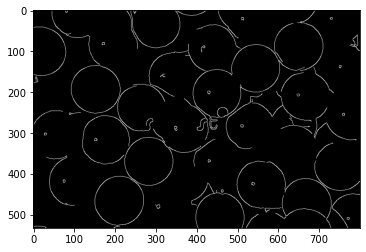

26036478


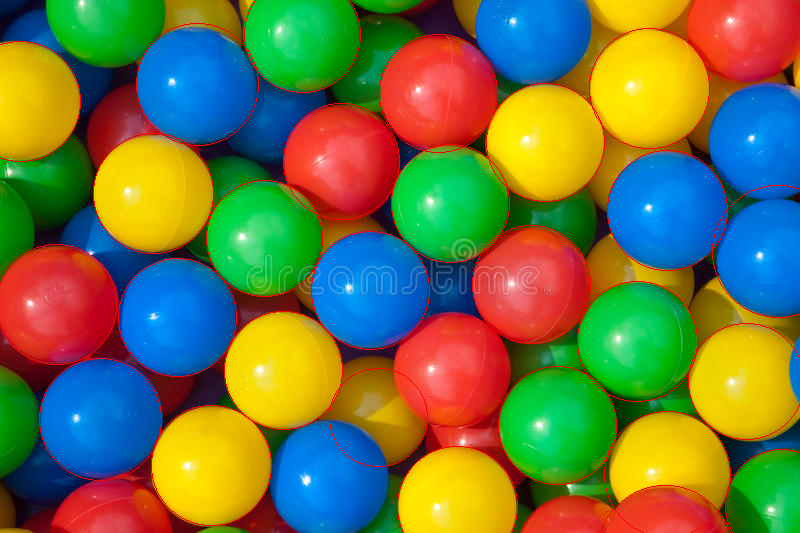

In [13]:
new_img = hough_transform()

new_img

In [14]:
oranges_gray = PIL.Image.open('oranges.jpg').convert('L')
oranges_gray

NameError: name 'PIL' is not defined

In [ ]:
oranges_gray = np.asarray(oranges_gray)
oranges_gray

In [ ]:
oranges_blurred = get_blurred(oranges_gray)

PIL.Image.fromarray(oranges_blurred)

In [ ]:
g, d = get_gradient(oranges_blurred)

filter_maxima(g, d)

keep = filter_edges(g, 20, 25)
keep

In [ ]:
img_for_canny = np.uint8(Image.open('balls.jpg').convert('L'))
blurred = cv2.GaussianBlur(img_for_canny, (5, 5), 0)
img_canny = cv2.Canny(img_for_canny, 40, 210)
plt.imshow(img_canny)

In [ ]:
img_canny[0:50, 0:50]

In [ ]:
img = Image.open('balls.jpg')

pixels_cords = canny_edge_detection(img)